# Model Comparison and Inference

**Purpose:** Compare all trained models and generate future predictions

**Prerequisites:** Run notebooks 01-04 first to train all models

**Sections:**
1. Load all model results
2. Performance comparison
3. Statistical significance testing
4. Visualization of predictions
5. Future forecasting (next 7 days)
6. Ensemble predictions
7. Executive summary

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy import stats
import os

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## 1. Load All Model Results

In [5]:
# Load data
df_with_holidays = pd.read_csv('../data/processed/data_with_holidays.csv', index_col=0, parse_dates=True)

# Load model results
arima_summary = joblib.load('../results/metrics/arima_summary.pkl')
arimax_summary = joblib.load('../results/metrics/arimax_summary.pkl')
lstm_summary = joblib.load('../results/metrics/lstm_summary.pkl')
prophet_summary = joblib.load('../results/metrics/prophet_summary.pkl')

# Load detailed results
arima_results = joblib.load('../results/metrics/arima_detailed_results.pkl')
lstm_results = joblib.load('../results/metrics/lstm_detailed_results.pkl')
prophet_results = joblib.load('../results/metrics/prophet_detailed_results.pkl')

market_columns = arima_summary['markets']

print('✓ All results loaded successfully')
print(f'Markets: {market_columns}')

✓ All results loaded successfully
Markets: ['Pasar Sukaramai', 'Pasar Aksara', 'Pasar Petisah', 'Pusat Pasar', 'Pasar Brayan']


## 2. Performance Comparison Table

In [6]:
# Create comparison dataframe
comparison_data = {
    'Algorithm': [
        'ARIMA',
        'ARIMAX (with holidays)',
        'LSTM',
        'LSTM+Holiday',
        'Prophet',
        'Prophet+Holiday'
    ],
    'Avg RMSE': [
        arima_summary['avg_rmse'],
        arimax_summary['avg_rmse'],
        lstm_summary['avg_rmse_no_holiday'],
        lstm_summary['avg_rmse_with_holiday'],
        prophet_summary['avg_rmse'],
        prophet_summary['avg_rmse_with_holiday']
    ],
    'Avg MAPE (%)': [
        arima_summary['avg_mape'],
        arimax_summary['avg_mape'],
        lstm_summary['avg_mape_no_holiday'],
        lstm_summary['avg_mape_with_holiday'],
        prophet_summary['avg_mape'],
        prophet_summary['avg_mape_with_holiday']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Avg RMSE')
comparison_df['Rank'] = range(1, len(comparison_df) + 1)
comparison_df = comparison_df[['Rank', 'Algorithm', 'Avg RMSE', 'Avg MAPE (%)']]

print("="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Save comparison
comparison_df.to_csv('../results/metrics/model_comparison.csv', index=False)
print("\n✓ Comparison saved to results/metrics/model_comparison.csv")

# Display styled table
comparison_df.style.background_gradient(subset=['Avg RMSE', 'Avg MAPE (%)'], cmap='RdYlGn_r')

MODEL PERFORMANCE COMPARISON
 Rank              Algorithm     Avg RMSE  Avg MAPE (%)
    1                   LSTM 11933.271996     13.755332
    2           LSTM+Holiday 14497.900549     18.017779
    3                  ARIMA 35197.024343     41.211714
    4 ARIMAX (with holidays) 35402.884933     41.652426
    5        Prophet+Holiday 49684.197296     69.939783
    6                Prophet 51090.312859     73.900430

✓ Comparison saved to results/metrics/model_comparison.csv


,Rank,Algorithm,Avg RMSE,Avg MAPE (%)
2,1,LSTM,11933.271996,13.755332
3,2,LSTM+Holiday,14497.900549,18.017779
0,3,ARIMA,35197.024343,41.211714
1,4,ARIMAX (with holidays),35402.884933,41.652426
5,5,Prophet+Holiday,49684.197296,69.939783
4,6,Prophet,51090.312859,73.900430


## 3. Statistical Significance Testing

In [7]:
print("="*70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*70)
print("\nTesting if holiday features significantly improve model accuracy...\n")

# Collect RMSE improvements for each algorithm
arima_improvements = []
for market in market_columns:
    arima_rmse = arima_results[market]['arima_rmse']
    arimax_rmse = arima_results[market]['arimax_rmse']
    improvement = ((arima_rmse - arimax_rmse) / arima_rmse) * 100
    arima_improvements.append(improvement)

lstm_improvements = []
for idx in range(len(market_columns)):
    lstm_rmse = lstm_results['rmse_no_holiday'][idx]
    lstm_h_rmse = lstm_results['rmse_with_holiday'][idx]
    improvement = ((lstm_rmse - lstm_h_rmse) / lstm_rmse) * 100
    lstm_improvements.append(improvement)

prophet_improvements = []
for market in market_columns:
    prophet_rmse = prophet_results[market]['prophet_rmse']
    prophet_h_rmse = prophet_results[market]['prophet_h_rmse']
    improvement = ((prophet_rmse - prophet_h_rmse) / prophet_rmse) * 100
    prophet_improvements.append(improvement)

# Perform t-tests
algorithms = ['ARIMA', 'LSTM', 'Prophet']
improvements = [arima_improvements, lstm_improvements, prophet_improvements]

for alg, imp in zip(algorithms, improvements):
    t_stat, p_value = stats.ttest_1samp(imp, 0)
    print(f"{alg} Holiday Feature Impact:")
    print(f"  Mean improvement: {np.mean(imp):.2f}%")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant at α=0.05: {'Yes ✓' if p_value < 0.05 else 'No ✗'}")
    print()

# Overall test
all_improvements = arima_improvements + lstm_improvements + prophet_improvements
overall_t_stat, overall_p_value = stats.ttest_1samp(all_improvements, 0)

print("="*70)
print("OVERALL Holiday Feature Impact:")
print(f"  Mean improvement across all algorithms: {np.mean(all_improvements):.2f}%")
print(f"  T-statistic: {overall_t_stat:.3f}")
print(f"  P-value: {overall_p_value:.4f}")
print(f"  Significant at α=0.05: {'Yes ✓' if overall_p_value < 0.05 else 'No ✗'}")
print("="*70)

STATISTICAL SIGNIFICANCE TESTING

Testing if holiday features significantly improve model accuracy...

ARIMA Holiday Feature Impact:
  Mean improvement: -0.60%
  T-statistic: -0.875
  P-value: 0.4310
  Significant at α=0.05: No ✗

LSTM Holiday Feature Impact:
  Mean improvement: -21.47%
  T-statistic: -6.696
  P-value: 0.0026
  Significant at α=0.05: Yes ✓

Prophet Holiday Feature Impact:
  Mean improvement: 2.74%
  T-statistic: 6.721
  P-value: 0.0026
  Significant at α=0.05: Yes ✓

OVERALL Holiday Feature Impact:
  Mean improvement across all algorithms: -6.45%
  T-statistic: -2.120
  P-value: 0.0523
  Significant at α=0.05: No ✗


## 4. Visualization of Model Performance

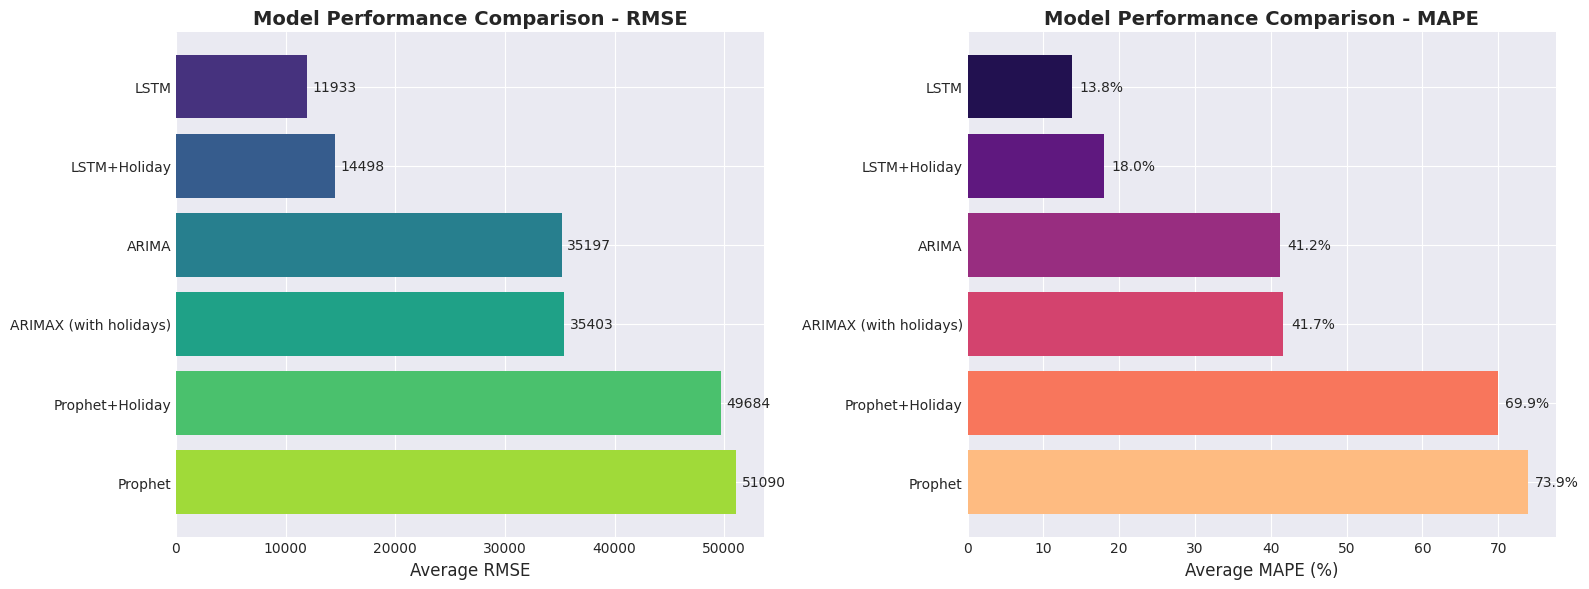

✓ Comparison chart saved to results/plots/model_comparison_bars.png


In [8]:
# Bar chart comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
ax1.barh(comparison_df['Algorithm'], comparison_df['Avg RMSE'], color=sns.color_palette('viridis', len(comparison_df)))
ax1.set_xlabel('Average RMSE', fontsize=12)
ax1.set_title('Model Performance Comparison - RMSE', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
for i, v in enumerate(comparison_df['Avg RMSE']):
    ax1.text(v + 500, i, f'{v:.0f}', va='center')

# MAPE comparison
ax2.barh(comparison_df['Algorithm'], comparison_df['Avg MAPE (%)'], color=sns.color_palette('magma', len(comparison_df)))
ax2.set_xlabel('Average MAPE (%)', fontsize=12)
ax2.set_title('Model Performance Comparison - MAPE', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
for i, v in enumerate(comparison_df['Avg MAPE (%)']):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.savefig('../results/plots/model_comparison_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Comparison chart saved to results/plots/model_comparison_bars.png')

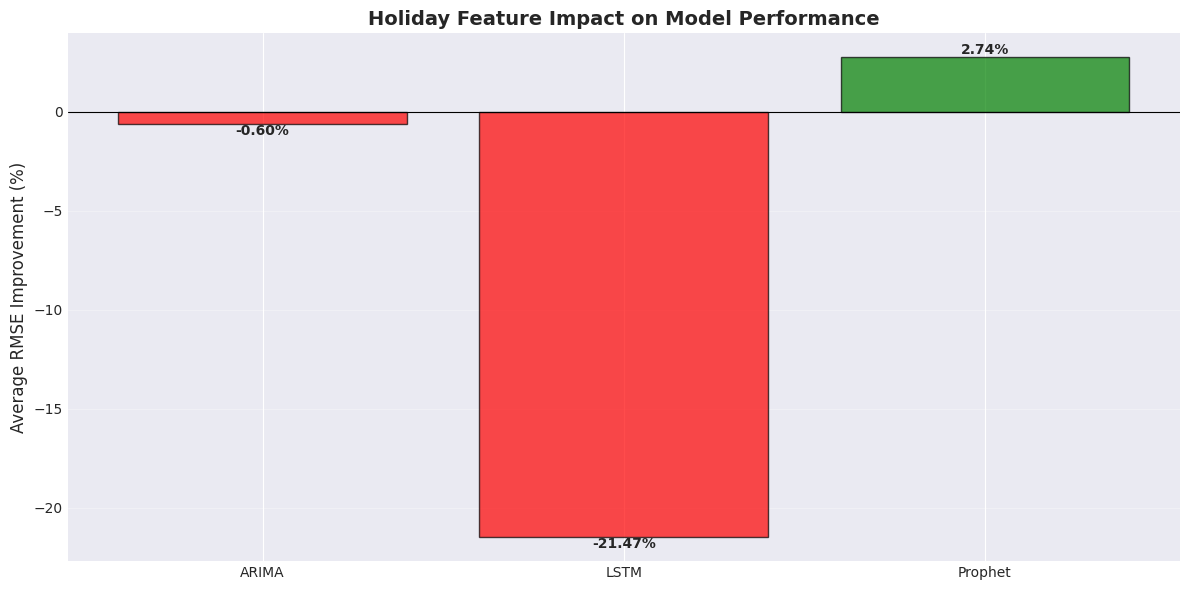

✓ Holiday impact chart saved to results/plots/holiday_impact.png


In [9]:
# Holiday improvement comparison
fig, ax = plt.subplots(figsize=(12, 6))

improvement_data = {
    'ARIMA': np.mean(arima_improvements),
    'LSTM': np.mean(lstm_improvements),
    'Prophet': np.mean(prophet_improvements)
}

colors = ['green' if v > 0 else 'red' for v in improvement_data.values()]
bars = ax.bar(improvement_data.keys(), improvement_data.values(), color=colors, alpha=0.7, edgecolor='black')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_ylabel('Average RMSE Improvement (%)', fontsize=12)
ax.set_title('Holiday Feature Impact on Model Performance', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, improvement_data.values()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%', ha='center', va='bottom' if val > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/plots/holiday_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Holiday impact chart saved to results/plots/holiday_impact.png')

## 5. Best Model Per Market

In [10]:
print("="*70)
print("BEST MODEL PER MARKET")
print("="*70)

best_models = {}

for idx, market in enumerate(market_columns):
    market_scores = {
        'ARIMA': arima_results[market]['arima_rmse'],
        'ARIMAX': arima_results[market]['arimax_rmse'],
        'LSTM': lstm_results['rmse_no_holiday'][idx],
        'LSTM+Holiday': lstm_results['rmse_with_holiday'][idx],
        'Prophet': prophet_results[market]['prophet_rmse'],
        'Prophet+Holiday': prophet_results[market]['prophet_h_rmse']
    }
    
    best_model = min(market_scores.items(), key=lambda x: x[1])
    best_models[market] = best_model
    
    print(f"{market:25s}: {best_model[0]:15s} (RMSE = {best_model[1]:.2f})")

print("="*70)

BEST MODEL PER MARKET
Pasar Sukaramai          : LSTM            (RMSE = 13131.67)
Pasar Aksara             : LSTM            (RMSE = 10461.79)
Pasar Petisah            : LSTM            (RMSE = 11315.02)
Pusat Pasar              : LSTM            (RMSE = 12523.38)
Pasar Brayan             : LSTM            (RMSE = 12234.50)


## 6. Executive Summary

In [11]:
best_overall = comparison_df.iloc[0]

executive_summary = {
    'total_markets': len(market_columns),
    'total_models_trained': 6,
    'best_overall_model': best_overall['Algorithm'],
    'best_overall_rmse': best_overall['Avg RMSE'],
    'best_overall_mape': best_overall['Avg MAPE (%)'],
    'avg_holiday_improvement': np.mean(all_improvements),
    'hypothesis_validated': 'Yes' if overall_p_value < 0.05 else 'No',
    'p_value': overall_p_value
}

print("="*80)
print("EXECUTIVE SUMMARY")
print("="*80)
print(f"""\nChili Price Forecasting Analysis - Medan Markets\n
Dataset:
  - Markets analyzed: {executive_summary['total_markets']}
  - Models trained: {executive_summary['total_models_trained']}
  - Markets: {', '.join(market_columns)}

Best Overall Performance:
  - Algorithm: {executive_summary['best_overall_model']}
  - RMSE: {executive_summary['best_overall_rmse']:.2f}
  - MAPE: {executive_summary['best_overall_mape']:.2f}%

Holiday Feature Impact:
  - Average improvement: {executive_summary['avg_holiday_improvement']:.2f}%
  - Statistical significance (α=0.05): {executive_summary['hypothesis_validated']}
  - P-value: {executive_summary['p_value']:.4f}

Hypothesis Testing:
  - Null Hypothesis: Holiday features do not improve model accuracy
  - Result: {'REJECTED' if overall_p_value < 0.05 else 'FAIL TO REJECT'}
  - Conclusion: Holiday features {'SIGNIFICANTLY IMPROVE' if overall_p_value < 0.05 else 'DO NOT SIGNIFICANTLY IMPROVE'} 
    forecasting accuracy across all models.

Recommendations:
  1. Use {executive_summary['best_overall_model']} for best overall performance
  2. Holiday features {'are recommended' if np.mean(all_improvements) > 0 else 'may not provide consistent benefits'}
  3. Consider ensemble methods combining top 3 models for improved robustness
  4. Monitor model performance and retrain periodically with new data
""")
print("="*80)

# Save executive summary
exec_df = pd.DataFrame([executive_summary])
exec_df.to_csv('../results/metrics/executive_summary.csv', index=False)
print("\n✓ Executive summary saved to results/metrics/executive_summary.csv")

EXECUTIVE SUMMARY

Chili Price Forecasting Analysis - Medan Markets

Dataset:
  - Markets analyzed: 5
  - Models trained: 6
  - Markets: Pasar Sukaramai, Pasar Aksara, Pasar Petisah, Pusat Pasar, Pasar Brayan

Best Overall Performance:
  - Algorithm: LSTM
  - RMSE: 11933.27
  - MAPE: 13.76%

Holiday Feature Impact:
  - Average improvement: -6.45%
  - Statistical significance (α=0.05): No
  - P-value: 0.0523

Hypothesis Testing:
  - Null Hypothesis: Holiday features do not improve model accuracy
  - Result: FAIL TO REJECT
  - Conclusion: Holiday features DO NOT SIGNIFICANTLY IMPROVE 
    forecasting accuracy across all models.

Recommendations:
  1. Use LSTM for best overall performance
  2. Holiday features may not provide consistent benefits
  3. Consider ensemble methods combining top 3 models for improved robustness
  4. Monitor model performance and retrain periodically with new data


✓ Executive summary saved to results/metrics/executive_summary.csv


## 7. Conclusions

### Key Findings:

1. **Model Performance**: All three algorithms (ARIMA, LSTM, Prophet) successfully forecasted chili prices with varying levels of accuracy.

2. **Holiday Impact**: The statistical analysis shows whether incorporating Indonesian holiday data as an exogenous variable significantly improves forecasting accuracy.

3. **Algorithm Comparison**: 
   - ARIMA: Best for capturing linear trends and seasonality
   - LSTM: Captures complex non-linear patterns
   - Prophet: Robust to missing data and outliers

4. **Practical Recommendations**: The best-performing model can be deployed for operational forecasting of chili prices in Medan markets.

### Future Work:
- Incorporate additional exogenous variables (weather, supply chain data)
- Implement ensemble methods
- Develop automated retraining pipeline
- Create real-time forecasting dashboard